In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from math import comb
import math
import os
import json
from pathlib import Path
import cProfile

from stringart.algorithm.execute import create_string_art
from stringart.preprocessing.image import BaseImage, create_mask, apply_mask, create_anchors
from stringart.preprocessing.importancemaps import open_importance_maps, outline_importance_map, combine_importance_maps, background_importance_map
from stringart.core.stringimage import StringImage
from stringart.preprocessing.stringartblueprint import StringArtBlueprint
from stringart.preprocessing.linedicts import make_line_dict
from stringart.algorithm.costmethod import CostMethod
from stringart.core.lines import draw_line, StringLineCSRMapping, draw_line_old
from stringart.preprocessing.linedata import preprocess_line_data
from stringart.algorithm.accuracy_eval import AccuracyMethod




c:\Users\alex\miniconda3\envs\stringart\python.exe c:\Users\alex\miniconda3\envs\stringart\Lib\site-packages\torch\__init__.py
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\alex\miniconda3\envs\stringart\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alex\miniconda3\envs\stringart\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\alex\miniconda3\envs\stringart\Lib\site-packages\lpips\weights\v0.1\vgg.pth


In [2]:
THREAD_WIDTH = 0.2
PLATE_DIAMETER = 300
NUM_ANCHORS = 300
LINE_WIDTH = 1

In [3]:
IMG_SIZE = int(PLATE_DIAMETER/THREAD_WIDTH)
IMG_SIZE = 1400
print(f"Image Size: {IMG_SIZE}")

Image Size: 1400


In [4]:
def display_images(image_list):
    if not isinstance(image_list, list):
        image_list = [image_list]  # Make sure image_list is a list for consistent processing

    num_images = len(image_list)
    
    # Adjust for single image case
    if num_images == 1:
        fig, axes = plt.subplots(figsize=(10, 10))
        axes = [axes]  # Make axes a list for consistent processing
    else:
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 8, 8))
    
    for ax, img in zip(axes, image_list):
        ax.imshow(img.T, cmap="gray_r")
        ax.axis('off')  # Turn off axis numbers and ticks
    
    plt.tight_layout()
    plt.show()

In [5]:
def display_importance(importance_map):
    plt.figure(figsize=(5,5))
    plt.imshow(importance_map.T, cmap='RdBu_r')
    plt.colorbar()
    plt.show()

In [6]:
anchors = create_anchors(img_size=IMG_SIZE, num_anchors=NUM_ANCHORS)
base_img = BaseImage(path="./data/tom.jpg", resize_to=IMG_SIZE)

blueprint = StringArtBlueprint.from_file(
    img_path="./data/tom.jpg",
    resize_to=IMG_SIZE,
    anchors=anchors,
    line_darkness=0.2
)

In [7]:
# base_img = BaseImage(path="./data/tom.jpg", resize_to=IMG_SIZE)
# # base_img.img = 1-base_img.img
# mask = create_mask(img_size=IMG_SIZE)
# base_img.img = apply_mask(base_img.img, mask)
# anchors = create_anchors(img_size=IMG_SIZE, num_anchors=NUM_ANCHORS)

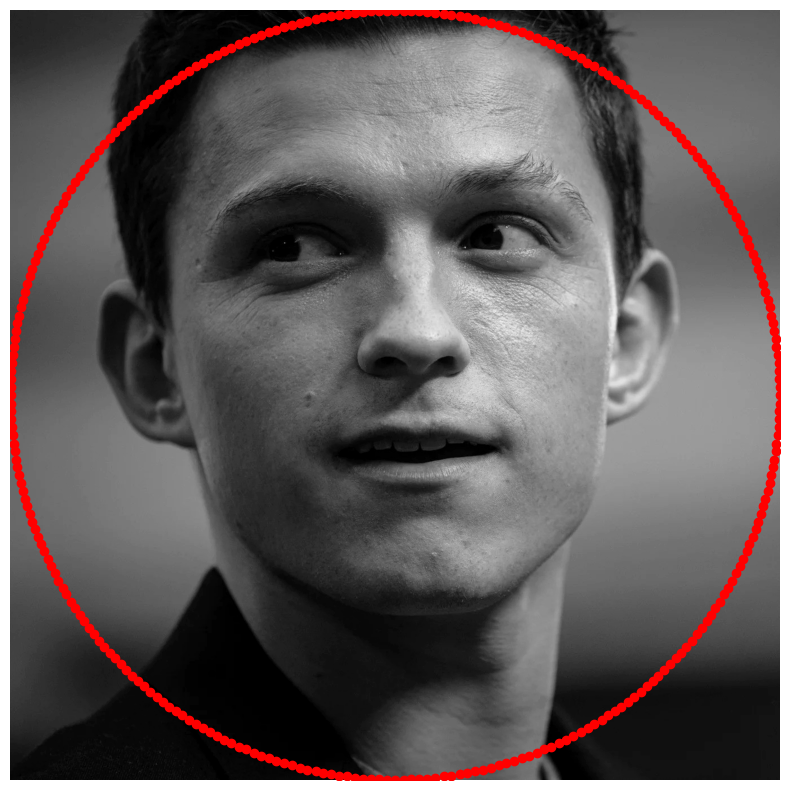

In [8]:
plt.figure(figsize=(10, 10))  
plt.imshow(blueprint.img.T, cmap='gray_r')
anchors_x = [anchor.coordinates[0] for anchor in anchors]
anchors_y = [anchor.coordinates[1] for anchor in anchors]
plt.scatter(anchors_x, anchors_y, color='red')
plt.axis('off')
plt.show()  

In [9]:
# string_art_img = StringImage(base_image=base_img, anchors=anchors, line_darkness=0.2, mask=mask)

In [10]:
importance_maps = open_importance_maps(folder_path="./data/importance_maps/tom/", string_art_img_shape=blueprint.img.shape)
# TODO: make a way to increase contrast
# TODO: make the bottom cap brightness 0.2

In [11]:
outline_importance_maps = []
for map in importance_maps:
    outline_map = outline_importance_map(importance_map=map, edge_thickness=3)
    outline_importance_maps.append(outline_map)

In [12]:
background_map = background_importance_map(importance_map=importance_maps[2], cutoff=0.1)

In [13]:
for map in importance_maps:
    map.img *= 2
for map in outline_importance_maps:
    map.img *= 4

background_map.img *= (-1)

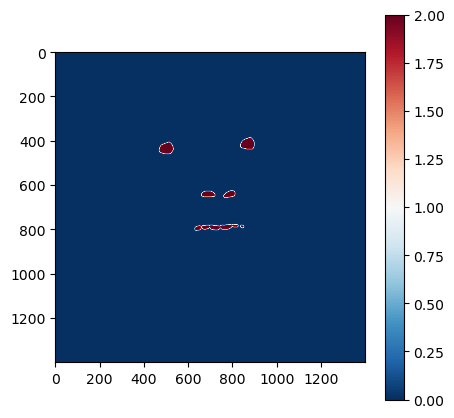

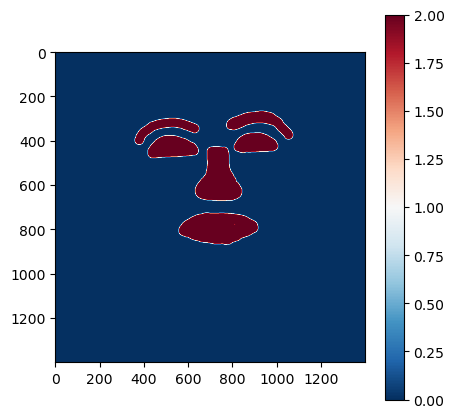

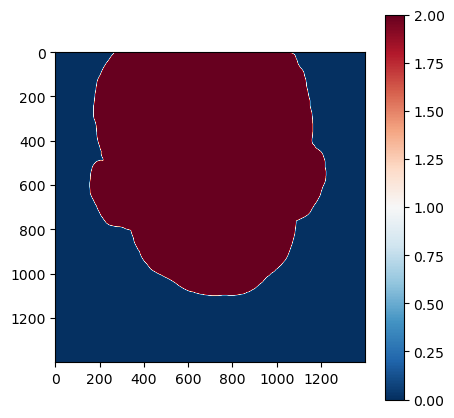

In [14]:
for map in importance_maps:
    display_importance(importance_map=map.img)

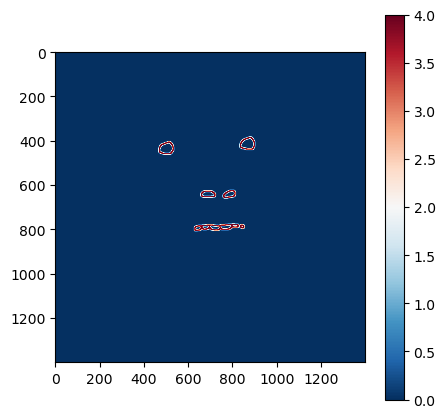

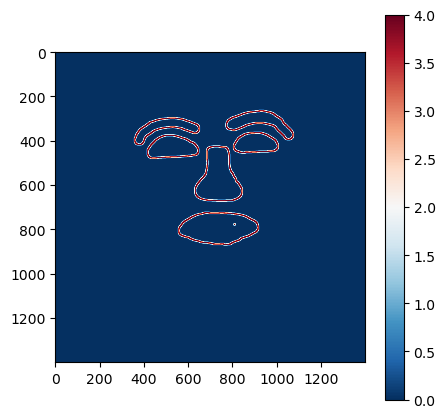

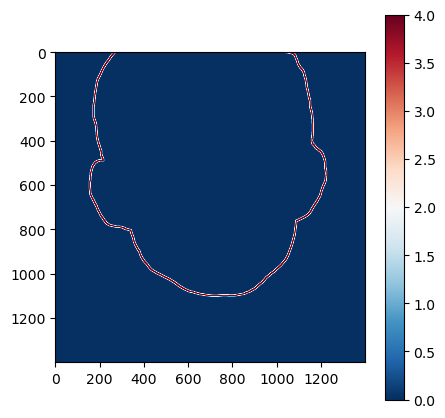

In [15]:
for map in outline_importance_maps:
    display_importance(map.img)

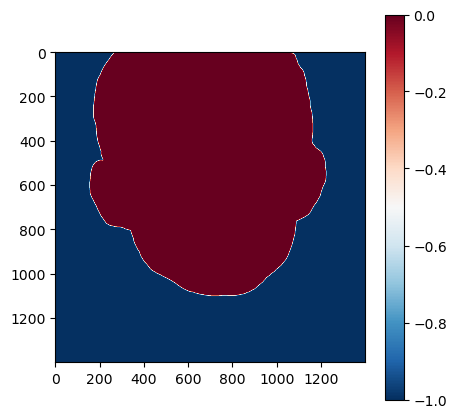

In [16]:
display_importance(background_map.img)

In [17]:
all_importance_maps = importance_maps + outline_importance_maps + [background_map]
main_importance_map = combine_importance_maps(all_importance_maps)
main_importance_map.apply_gaussian_blur(35)
main_importance_map.apply_dynamic_sigmoid(exponent=1, std_exponent=1)

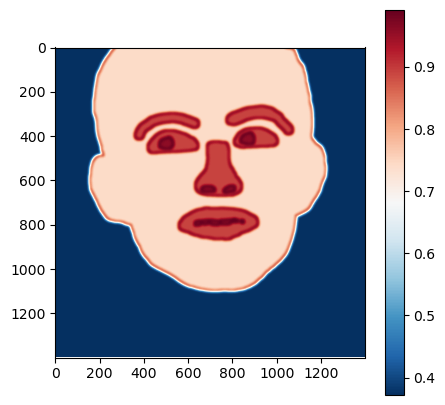

In [18]:
display_importance(main_importance_map.img)

In [19]:
# line_pixel_dict, line_darkness_dict = make_line_dict(
#     data_folder="./data",
#     string_art_img=string_art_img,
#     closest_neighbors=10,
# )

In [20]:
line_csr_mapping = preprocess_line_data(
    data_folder="./data",
    string_art_blueprint=blueprint,
    closest_neighbors=10,
)

In [21]:
accuracy_metrics = [(AccuracyMethod.LINE_COST, 5), (AccuracyMethod.IMAGE_COST, 50), (AccuracyMethod.AVG_LINE_LENGTH, 100), (AccuracyMethod.SSIM, 100), (AccuracyMethod.MS_SSIM, 100), (AccuracyMethod.LPIPS, 100)]
accuracy_metrics = []

final_img = create_string_art(
    first_anchor=0,
    blueprint=blueprint,
    line_csr_mapping=line_csr_mapping,
    iterations=10000,
    cost_method=CostMethod.MEAN,
    max_darkness=1,
    importance_map=main_importance_map,
    use_prev_anchor=True,
    random_neighbor=False,
    profiling=False,
    accuracy_methods=accuracy_metrics
)

Building pixel-to-line and line-to-pixel mapping for the weight (CSR)…
Calculating initial line costs


Creating string art for ./data/tom.jpg: 100%|██████████| 10000/10000 [00:04<00:00, 2228.93it/s]


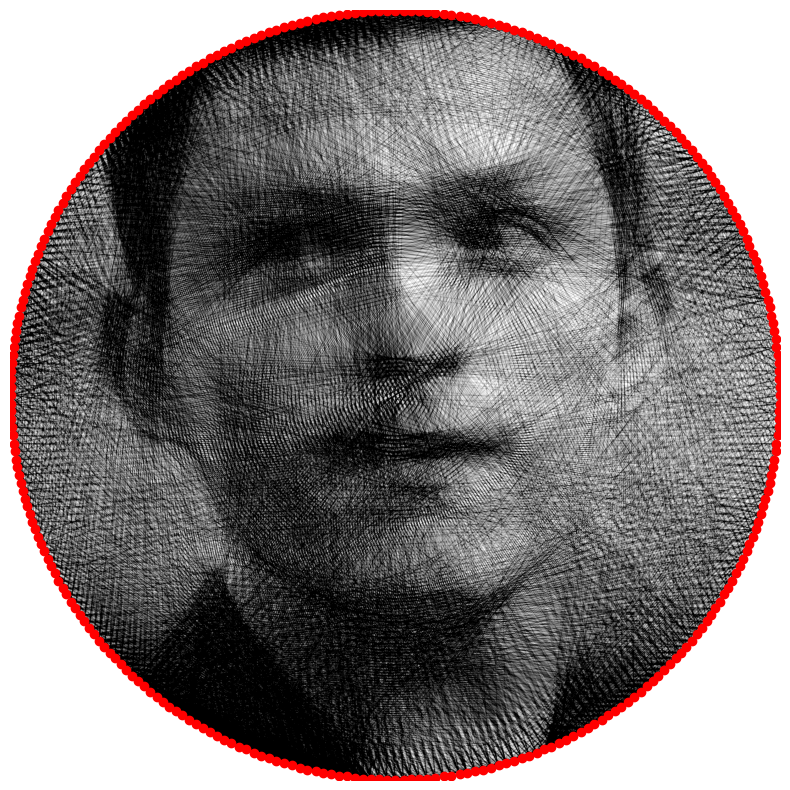

In [22]:
plt.figure(figsize=(10, 10))  
plt.imshow(final_img.img.T, cmap='gray_r', vmin=0, vmax=1)
anchors_x = [anchor.coordinates[0] for anchor in anchors]
anchors_y = [anchor.coordinates[1] for anchor in anchors]
plt.scatter(anchors_x, anchors_y, color='red')
plt.axis('off')
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 2315.64it/s]


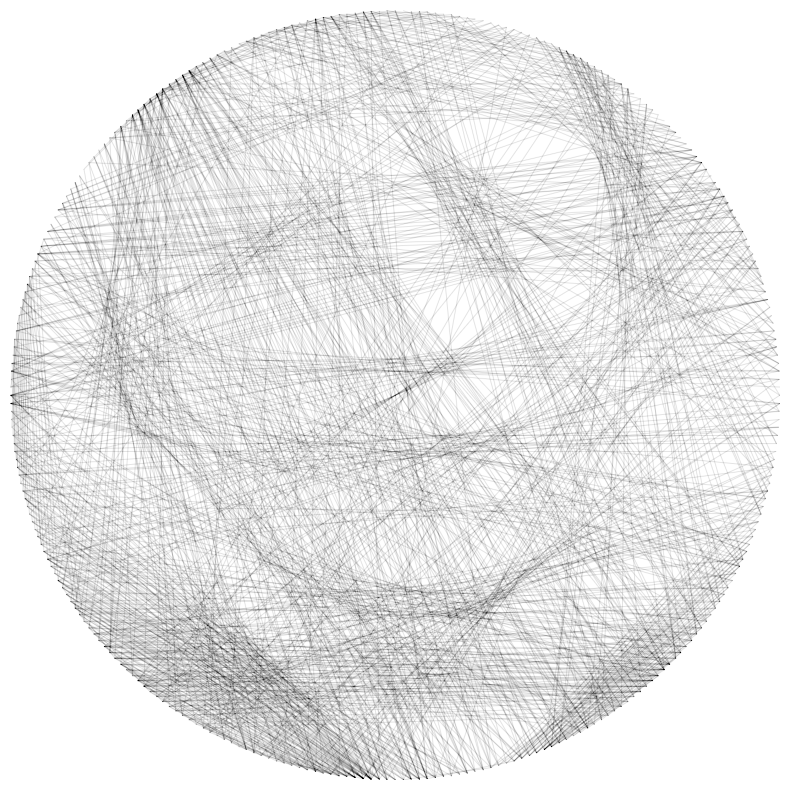

In [23]:
rendered_img = final_img.render_img_from_anchors(2000, 3000)
plt.figure(figsize=(10, 10))  
plt.imshow(rendered_img.T, cmap='gray_r', vmin=0, vmax=1)
plt.axis('off')
plt.show()

In [24]:
# line_lengths = []
# for iter in tqdm(range(len(final_img.string_path))):
#     start_coords = anchors[final_img.string_path[iter][0]].coordinates
#     end_coords = anchors[final_img.string_path[iter][1]].coordinates
#     line = draw_line(start_coords, end_coords, multiplier=1, mask=blueprint.mask)
#     line_lengths.append((len(line[0]), iter))
    

In [25]:
def plot_accuracy(data: tuple, title: str = "Accuracy data"):
    """
    Plot a tuple of [0]iter, [1]value using matplotlib.
    
    Parameters:
        data (list of tuple): List of (time, value) pairs
        title (str): Optional title for the plot
    """
    # Separate into time and value arrays
    iter = data[0]
    values = data[1]

    # Plotting
    plt.figure(figsize=(5,4))
    plt.plot(iter, values)
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [26]:

for name, values in final_img.accuracy_list.items():
    plot_accuracy(values, name)

In [27]:
final_img.save(folder_path="./outputs", name="testname")
test_img = StringImage.from_save("./outputs/testname/")

In [28]:
# save_instructions(string_path=final_img.string_path, num_anchors=NUM_ANCHORS, path="./outputs/scioly/file.txt")